# Анализ данных

В качестве тренировки будем прогнозировать температуру на улице в зависимости от дня в году на основе исторических даных. Построим разные модели, научимся их сравнивать и выберем лучшую.

Данные взяты с сайта https://rp5.ru/Архив_погоды_в_Москве_(ВДНХ)

1) Протестировать качество модели DecisionTreeRegressor + cos(день в году)

2) Поиграть с признаками - добавить больше признаков в модель (sin, sin & cos, dayofyear & cos и т.п.)

_Сданной считается работа, в которой проделаны эксперименты хотя бы по одному из пунктов, даже если код не удалось заставить работать  :)


# Ссылки на ресурсы
[Визуализация работы Дерева Решений (Decision Tree)](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)


[Документация pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)

[Документация sklearn Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

[Документация sklearn DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)


#Инструкция: получение ссылки на датасет
(Это необязательный шаг, все будет работать с уже вставленной ссылкой. Инструкция дана на случай, если вам захочется использовать данные из другого города или в другие даты.)


Нажимаем кнопку "Выбрать в файл GZ (архив)" и формат файла Excel файлом за интересующий период (с 2016 года). Рядом появляется ссылка "Скачать". Правая кнопка мыши -> Копировать ссылку

Пример команды для скачивания (подставить свою ссылку):

```!wget -O "weather.xls.gz" "http://93.90.217.253/download/files.synop/27/27612.01.01.2016.16.08.2021.1.0.0.ru.utf8.00000000.xls.gz"```

Распаковка архива:

```!gzip -df "weather.xls.gz"```

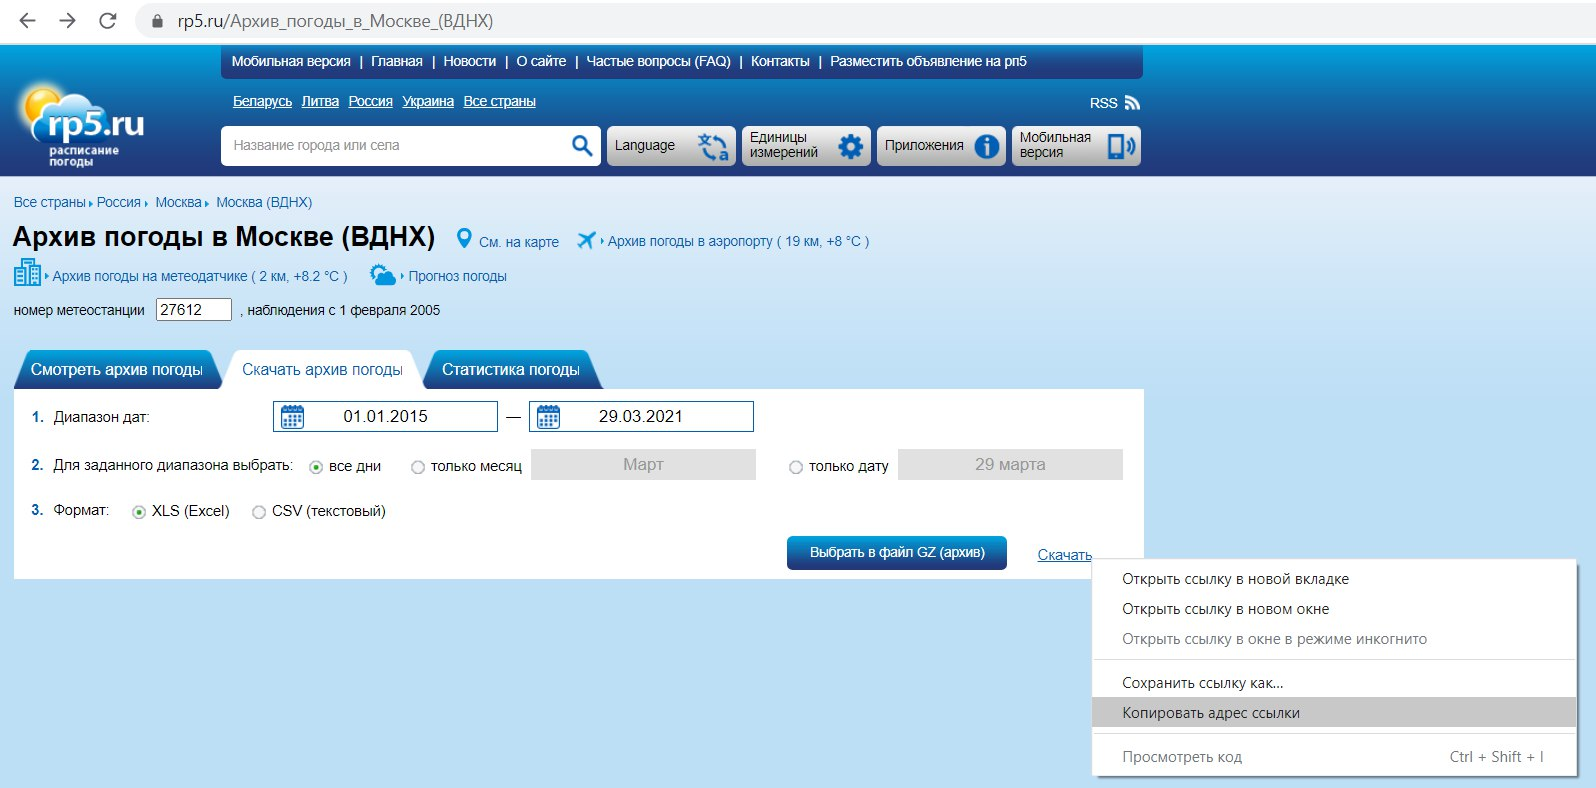

Скопированную ссылку нужно вставить в [ячейку ниже](https://colab.research.google.com/drive/1qW_BLu6uE1DMqWBbdMDY-Fgrfkh2w4jh#scrollTo=dXj4bNhOcxpM&line=1&uniqifier=1) и выполнить ее и следующую за ней (команды `!wget` и `!gzip`).


Чтобы после скачивания увидеть изменения в списке файлов, нажмите кнопку "обновить"



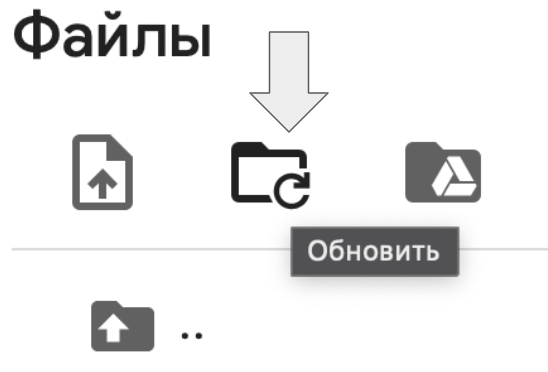


# Часть 1: скачиваем и визуализируем данные

In [ ]:
! pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 5.9 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [ ]:
# Скачивание файла (подставить свою ссылку)
!wget -O "weather.xls.gz" "http://93.90.217.252/download/files.synop/27/27612.01.01.2016.18.10.2021.1.0.0.ru.utf8.00000000.xls.gz"
# Распаковка архива
!gzip -df "weather.xls.gz"

--2022-11-02 14:44:31--  http://93.90.217.252/download/files.synop/27/27612.01.01.2016.18.10.2021.1.0.0.ru.utf8.00000000.xls.gz
Connecting to 93.90.217.252:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1403974 (1.3M) [application/octet-stream]
Saving to: ‘weather.xls.gz’

weather.xls.gz      100%[===================>]   1.34M   762KB/s    in 1.8s    

2022-11-02 14:44:33 (762 KB/s) - ‘weather.xls.gz’ saved [1403974/1403974]



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Считываем Excel-таблицу в переменную data, удаляем первые 6 строк комментарией
data = pd.read_excel('weather.xls', skiprows=6)
# Удаляем пропуски
data = data[data['T'].notna()]
data = data[data['P'].notna()] #удаляем пропуски у нового признака
#не самый оптимальный вариант, но работает =)
data['N']=data.N.replace('%','',regex=True)
data['N']=data.N.replace('90  или более, но не 100','90',regex=True)
data['N']=data.N.replace('70 – 80','70',regex=True)
data['N']=data.N.replace('Облаков нет.','0',regex=True)
data['N']=data.N.replace('20–30.','20',regex=True)
data['N']=data.N.replace('10  или менее, но не 0','10',regex=True)
data['N']=data.N.replace('Небо не видно из-за тумана и/или других метеорологических явлений.','50',regex=True)
data['N']=data.N.astype(float)
data = data[data['N'].notna()]
# Преобразуем российский формат дат для дальнейшего анализа
data['date'] = pd.to_datetime(data['Местное время в Москве (ВДНХ)'], dayfirst=True)

In [ ]:
# Распечатаем первые 10 строк таблицы
data.head(10)

,Местное время в Москве (ВДНХ),T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Ch,VV,Td,RRR,tR,E,Tg,E',sss,date
0,18.10.2021 18:00,4.1,743.6,757.4,0.4,86.0,"Ветер, дующий с западо-северо-запада",1,NaN,NaN,...,"Перистых, перисто-кучевых или перисто-слоистых...",17.0,1.9,3,12.0,NaN,NaN,NaN,NaN,2021-10-18 18:00:00
1,18.10.2021 15:00,6.1,743.2,756.9,0.2,63.0,"Ветер, дующий с запада",1,NaN,NaN,...,"Перистых, перисто-кучевых или перисто-слоистых...",20.0,-0.4,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-18 15:00:00
2,18.10.2021 12:00,5.1,743.0,756.7,1.3,85.0,"Ветер, дующий с запада",1,NaN,NaN,...,"Перистых, перисто-кучевых или перисто-слоистых...",20.0,2.7,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-18 12:00:00
3,18.10.2021 09:00,5.8,741.7,755.5,-0.9,93.0,"Ветер, дующий с западо-юго-запада",1,NaN,NaN,...,NaN,8.0,4.7,0.6,12.0,Поверхность почвы влажная.,4.0,NaN,NaN,2021-10-18 09:00:00
4,18.10.2021 06:00,6.2,742.6,756.3,-1.1,84.0,"Ветер, дующий с юга",1,NaN,NaN,...,NaN,20.0,3.7,Осадков нет,12.0,NaN,NaN,NaN,NaN,2021-10-18 06:00:00
5,18.10.2021 03:00,7.1,743.7,757.3,-0.9,82.0,"Ветер, дующий с западо-юго-запада",1,NaN,NaN,...,NaN,20.0,4.2,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-18 03:00:00
6,18.10.2021 00:00,6.7,744.6,758.3,-0.7,83.0,"Штиль, безветрие",0,NaN,NaN,...,"Перистых, перисто-кучевых или перисто-слоистых...",20.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-18 00:00:00
7,17.10.2021 21:00,6.6,745.3,759.0,0.1,82.0,"Штиль, безветрие",0,NaN,NaN,...,"Перистых, перисто-кучевых или перисто-слоистых...",20.0,3.7,Осадков нет,12.0,NaN,NaN,NaN,NaN,2021-10-17 21:00:00
8,17.10.2021 18:00,7.9,745.2,758.8,-0.4,76.0,"Ветер, дующий с западо-юго-запада",1,NaN,NaN,...,NaN,20.0,3.9,Осадков нет,12.0,NaN,NaN,NaN,NaN,2021-10-17 18:00:00
9,17.10.2021 15:00,7.8,745.6,759.3,-0.6,73.0,"Ветер, дующий с западо-юго-запада",1,NaN,NaN,...,NaN,20.0,3.3,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-17 15:00:00


In [ ]:
# Атрибут объекта - список колонок
data.columns

Index(['Местное время в Москве (ВДНХ)', 'T', 'Po', 'P', 'Pa', 'U', 'DD', 'Ff',
       'ff10', 'ff3', 'N', 'WW', 'W1', 'W2', 'Tn', 'Tx', 'Cl', 'Nh', 'H', 'Cm',
       'Ch', 'VV', 'Td', 'RRR', 'tR', 'E', 'Tg', 'E'', 'sss', 'date'],
      dtype='object')

In [ ]:
# Pandas DataFrame (наша data) - это таблицы, которые хранятся по столбцам,
# т.е. если мы хотим получить данные о температуре в строке 15,
# мы в квадратных скобках пишем сначала название колонки, потом номер строки
print('Температура в строке 15 =', data['T'][15])
data['T']

Температура в строке 15 = 8.0


0         4.1
1         6.1
2         5.1
3         5.8
4         6.2
         ... 
16933   -15.0
16934   -14.8
16935   -14.6
16936   -14.0
16937   -12.9
Name: T, Length: 16891, dtype: float64

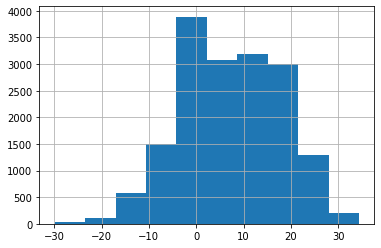

In [ ]:
# Гистограмма - график, который показывает, сколько раз встречалось то или иное значние
data['T'].hist()

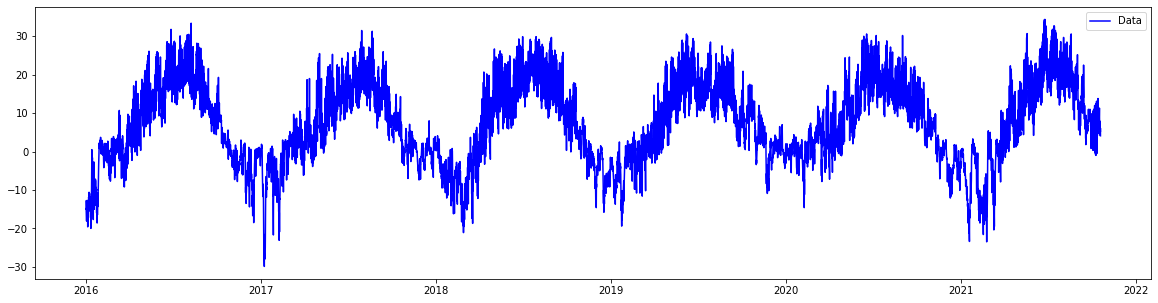

In [ ]:
# Строим график с помощью функции из библиотеки matplotlib (загрузили ее с коротким именем plt)
plt.figure(figsize=(20, 5))
plt.plot(data['date'], data['T'], color='blue', label='Data')
plt.legend()

# Разбор упражнения  1-го дня

In [ ]:
# Приблизить график аномалии в 2017 году (например, обрезать с ноября 2016 по март 2017)
# 1) Это упражнение можно сделать, скомбинировав код с вебинара
# 2) Есть много способов сделать это в 1 строчку, гуглить можно и нужно (задание со *)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


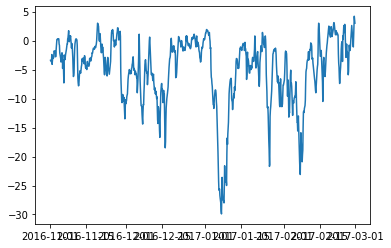

In [ ]:
# 1) вариант как можно было делать упражнение:
# data['date'] > '2016-11-01'
# data['date'] < '2017-03-01'

condition1 = data['date'] > '2016-11-01'
data_short = data[condition1]
condition2 = data['date'] < '2017-03-01'
data_short2 = data_short[condition2]
plt.plot(data_short2['date'], data_short2['T'])

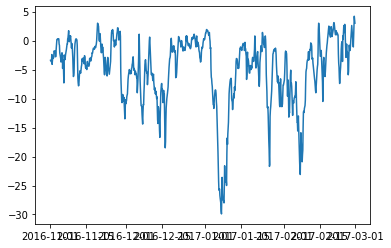

In [ ]:
# 2) вариант в одну строку

# condition = (data['date'] < '2017-03-01') & (data['date'] > '2016-11-01')

data_short2 = data[(data['date'] < '2017-03-01') & (data['date'] > '2016-11-01')]

plt.plot(data_short2['date'], data_short2['T'])

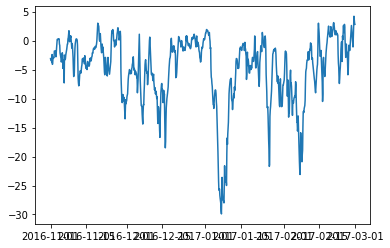

In [ ]:
# 3) вариант в одну строку с помощью функции between

data_short2 = data[data['date'].between('2016-11-01', '2017-03-01')]

plt.plot(data_short2['date'], data_short2['T'])

# Что значит "Построить модель"?

Что имеем: какой-то график реальных данных. Этот график пытаемся повторить какой-то функцией $y = f(x)$.

Работа Data Scientist - подобрать наиболее близкую функцию с помощью инструментов машинного обучения.


* y  -  **target** (таргет, целевая переменная) - величина, которую хотим прогнозировать. В данном случае это температура из колонки `data['T']`.
* X -  **features** (признаки) -  факторы, по которым хотим прогнозировать что-то. В нашем случае это день в году. Можно выбрать / сконструировать другие признаки. Это входит в работу Data Scientist.

# Сегодня построим 2 модели
1. **Линейная регрессия** (LinearRegression) Посмотрим на данные глазами, подумаем, на какую функцию похож график, автоматически инструментами ML подберем коэффициенты функции так, чтобы графики совпали.  
2. **Дерево решений** (DecisionTree) Построим альтернативную модель, которая строит ступенчатую функцию, и сравним численно, какая модель лучше годится для прогноза.

Чтобы обучить модель (любую), нужно пройти 2 предварительные стадии:

1.   Сгенерировать новые признаки (если нужно)
2.   Разделить данные на 2 _выборки_ (2 набора записей) - для обучения модели и для тестирования


In [ ]:
# Сгенерируем новый признак: день в году

data['dayofyear'] = data['date'].dt.dayofyear

In [ ]:
data.head(5)

,Местное время в Москве (ВДНХ),T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,VV,Td,RRR,tR,E,Tg,E',sss,date,dayofyear
0,18.10.2021 18:00,4.1,743.6,757.4,0.4,86.0,"Ветер, дующий с западо-северо-запада",1,NaN,NaN,...,17.0,1.9,3,12.0,NaN,NaN,NaN,NaN,2021-10-18 18:00:00,291
1,18.10.2021 15:00,6.1,743.2,756.9,0.2,63.0,"Ветер, дующий с запада",1,NaN,NaN,...,20.0,-0.4,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-18 15:00:00,291
2,18.10.2021 12:00,5.1,743.0,756.7,1.3,85.0,"Ветер, дующий с запада",1,NaN,NaN,...,20.0,2.7,NaN,NaN,NaN,NaN,NaN,NaN,2021-10-18 12:00:00,291
3,18.10.2021 09:00,5.8,741.7,755.5,-0.9,93.0,"Ветер, дующий с западо-юго-запада",1,NaN,NaN,...,8.0,4.7,0.6,12.0,Поверхность почвы влажная.,4.0,NaN,NaN,2021-10-18 09:00:00,291
4,18.10.2021 06:00,6.2,742.6,756.3,-1.1,84.0,"Ветер, дующий с юга",1,NaN,NaN,...,20.0,3.7,Осадков нет,12.0,NaN,NaN,NaN,NaN,2021-10-18 06:00:00,291


# Модель 1: Линейная регрессия
Истинная модель - какая-то функция $y = f(x)$.

Пытаемся подобрать функцию z(x), которая просто вычисляется и максимально похожа на f(x).

Самая простая модель - линейная регрессия, которая подбирает коэффициенты
$z = ax+b$



* Коэффициенты a и b - **параметры** модели. Они подбираются автоматически

------------------------------------------

# Данные похожи на какую-нибудь функцию, знакомую нам со школы?

График реальных данных VS Примеры простейших функций


Какую функцию будем пытаться подогнать?

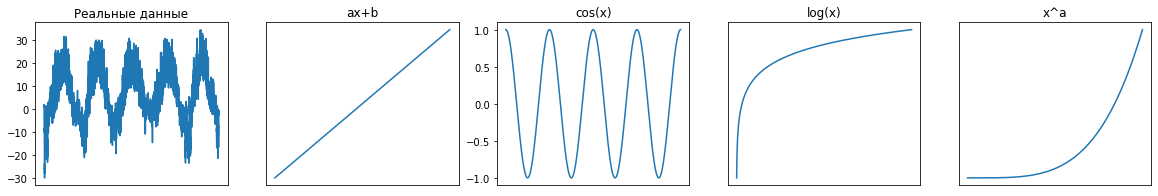

Данные очень похожи на косинус. Но его нужно подогнать к нашим данным:
1. **по периоду** (растянуть в ширину) - сделаем вручную (т.к. знаем и длительность года, и период косинуса)
2. **по амплитуде** (растянуть в высоту) - подберем коэффициенты с помощью линейной регрессии.

# 1 подготовительный шаг: сгенерируем новый признак

In [ ]:
# Подключаем библиотеку с математическими функциями
import numpy as np

In [ ]:
# Новый признак: косинус от дня в году.
# Период [1, 366] перегоним в период [0, 2*pi) (подгоняем косинусоиду по ширине)
# день в году в радианах = (dayofyear - 1) / 366 * 2*pi
# косинус от дня в году = cos(день в году в радианах из диапазона 0 до 2*pi)

data['cos_dayofyear'] = np.cos((data['dayofyear']-1) / 366 * 2 * np.pi)

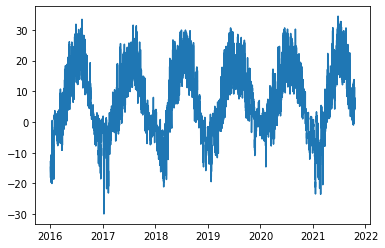

In [ ]:
plt.plot(data['date'], data['T'])

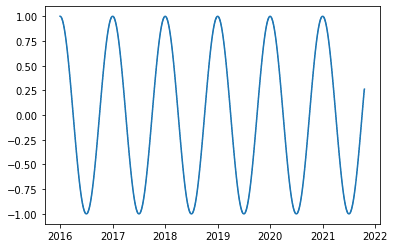

In [ ]:
plt.plot(data['date'], data['cos_dayofyear'])

# 2 подготовительный шаг - Разделение данных на train-test

Вначале нужно разбить данные на 2 выборки: на тренировочную (обучающую, train) и тестовую (валидационную, test, val)

На обучающей выборке модель подгоняет свои внутренние параметры с помощью статистики (шаг "обучение", fit)

На тестовой выборке мы тестируем качество модели, на ней она как студент проходит экзамен

Если студент вызубрил ответы, но ничего не понял - точность ответов на тренировочной выборке будет высокой, а на тестовой - очень низкой

In [ ]:
# data_train - обучающая выборка
# data_test - тестовая выборка

In [ ]:
data_train = data[data['date'] < '2020-01-01']
data_test = data[data['date'] >= '2020-01-01']

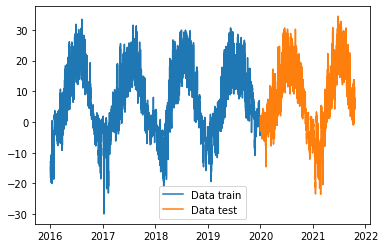

In [ ]:
plt.plot(data_train['date'], data_train['T'], label='Data train')
plt.plot(data_test['date'], data_test['T'], label='Data test')
plt.legend()

In [ ]:
# Для того, чтобы обучить модель, нужно еще раз разделить выборку
# на фичи (признаки, features, X) и таргет (целевую переменную, которую прогнозируем, target, y)
# 2 датасета train-test х 2 features-target - создаем 4 переменных:
# X_train, y_train, X_test, y_test
#
#
# Мы будем делать прогноз только на одном факторе - номере дня в году data['dayofyear']
# Но модель ожидает, что ей на вход придет двумерная таблица с многими факторами -
# поэтому создаем из колонки date['T'] полноценную таблицу pandas DataFrame

X_train = pd.DataFrame()
X_train['cos_dayofyear'] = data_train['cos_dayofyear']

X_test = pd.DataFrame()
X_test['cos_dayofyear'] = data_test['cos_dayofyear']
# "y" оставляем столбцом, как есть

y_train = data_train['T']
y_test = data_test['T']

In [ ]:
X_train.head()

,cos_dayofyear
5254,0.999411
5255,0.999411
5256,0.999411
5257,0.999411
5258,0.999411


# 1 модель: Линейная регрессия (Linear Regression)

Будем с ее помощью подгонять коэффициент при косинусе так, чтобы растянуть его в высоту до уровня наших данных

$z = a \cos(dayofyear) + b$

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
# Создаем пустой объект со случайными a и b, которые пока не описывают наши данные
model = LinearRegression()

In [ ]:
# Возвращаемся к подготовительному шагу - разделяем x (cos_dayofyear) и y (data['T'])
# Получаем 2 таблицы X_train, X_test и 2 столбца y_train, y_test

data['cos_dayofyear'] = np.cos((data['dayofyear']-1) / 366 * 2 * np.pi)

data_train = data[data['date'] < '2020-01-01']
data_test = data[data['date'] >= '2020-01-01']

X_train = pd.DataFrame()
X_train['cos_dayofyear'] = data_train['cos_dayofyear']

X_test = pd.DataFrame()
X_test['cos_dayofyear'] = data_test['cos_dayofyear']
# "y" оставляем столбцом, как есть

y_train = data_train['T']
y_test = data_test['T']

In [ ]:
# Обучаем модель: подгоняем модель по данным X_train и говорим "правильные ответы" - y_train
model.fit(X_train, y_train)

LinearRegression()

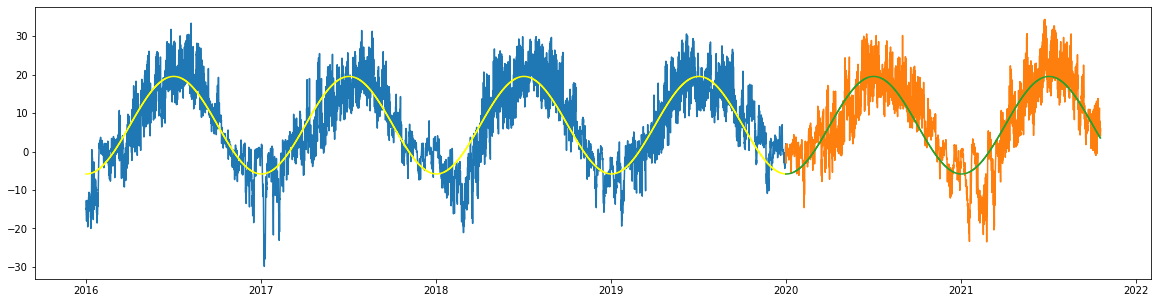

In [ ]:
# Посмотрим, какую мат. модель построила регрессия по данным, поэтому распечатаем
# прогноз для тренировочных данных

pred_train = model.predict(X_train)
# Прогноз на данных, которые модель еще не видела
pred_test = model.predict(X_test)

# Распечатаем графики
plt.figure(figsize=(20, 5))
plt.plot(data_train['date'], y_train)
plt.plot(data_test['date'], y_test)
plt.plot(data_train['date'], pred_train, color='yellow')
plt.plot(data_test['date'], pred_test)

In [ ]:
# Проверяем качество численно

# mean_absolute_error - средняя сумма отклонений (меньше -> лучше)

from sklearn.metrics import mean_absolute_error

print('Средняя ошибка на тестовой выборке =', mean_absolute_error(y_test, pred_test))

Средняя ошибка на тестовой выборке = 4.580773112585146


Средняя ошибка на обучающей выборке = 4.272995513347085
Средняя ошибка на тестовой выборке = 4.580773112585146


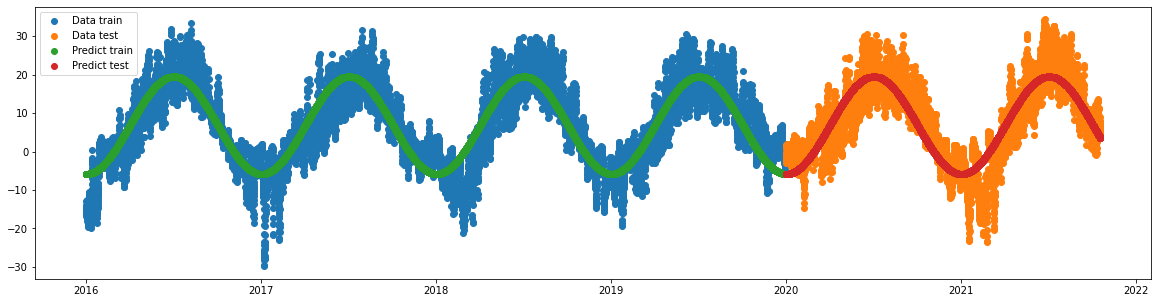

In [ ]:
# Собираем все шаги воедино

# Новый признак: косинус от дня в году
data['cos_dayofyear'] = np.cos((data['dayofyear'] - 1) / 366 * 2 * np.pi)

# Заново переразбиваем датасет на train-test, чтобы изменения применились
data_train = data[data['date'] < '2020-01-01']
data_test = data[data['date'] >= '2020-01-01']

# Из train-test формируем X_train, X_test
X_train = pd.DataFrame()
X_train['cos_dayofyear'] = data_train['cos_dayofyear']  # X
X_test = pd.DataFrame()
X_test['cos_dayofyear'] = data_test['cos_dayofyear']
# "y" оставляем прежним
y_train = data_train['T']
y_test = data_test['T']

# Создаем модель и обучаем ее
model = LinearRegression()
model.fit(X_train, y_train)

# Делаем прогноз
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Печатаем графики
plt.figure(figsize=(20, 5))
plt.scatter(data_train['date'], y_train, label='Data train')
plt.scatter(data_test['date'], y_test, label='Data test')
plt.scatter(data_train['date'], pred_train, label='Predict train')
plt.scatter(data_test['date'], pred_test, label='Predict test')
plt.legend()

# Смотрим на величину ошибки
print('Средняя ошибка на обучающей выборке =', mean_absolute_error(y_train, pred_train))
print('Средняя ошибка на тестовой выборке =', mean_absolute_error(y_test, pred_test))

# 1) LinearRegression + cos_dayofyear
# Средняя ошибка на обучающей выборке = 4.273310125395435
# Средняя ошибка на тестовой выборке = 4.578715441934872

# 2 Модель: Дерево решений (Decision Tree)
http://www.r2d3.us/visual-intro-to-machine-learning-part-1/

In [ ]:
from sklearn.tree import DecisionTreeRegressor

Здесь косинусное преобразование уже не нужно - будем делать прогноз на исходном факторе "день в году"

Средняя ошибка на обучающей выборке = 3.642491416923723
Средняя ошибка на тестовой выборке = 4.655280661599759


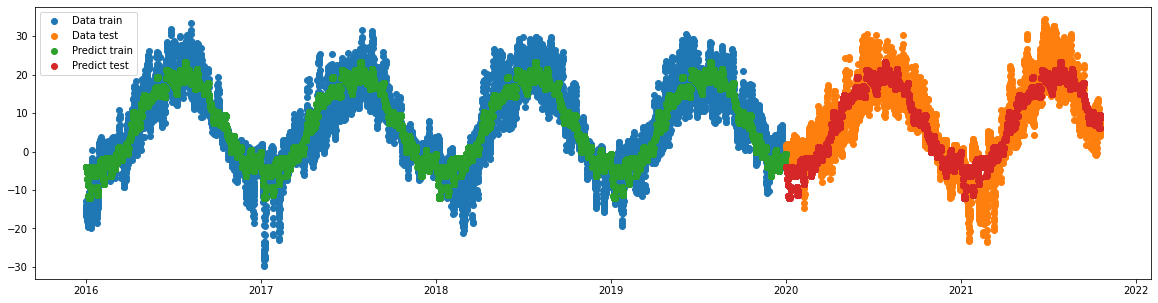

In [ ]:
# 2) Decision Tree + dayofyear

# Собираем все шаги воедино

# Новый признак: косинус от дня в году
# data['cos_dayofyear'] = np.cos((data['dayofyear'] - 1) / 366 * 2 * np.pi)
data['dayofyear'] = data['date'].dt.dayofyear # <<<<<<< Вот здесь заменили признак X

# Заново переразбиваем датасет на train-test, чтобы изменения применились
data_train = data[data['date'] < '2020-01-01']
data_test = data[data['date'] >= '2020-01-01']

# Из train-test формируем X_train, X_test
X_train = pd.DataFrame()
X_train['dayofyear'] = data_train['dayofyear']  # <<<<<<< Вот здесь заменили модель
X_test = pd.DataFrame()
X_test['dayofyear'] = data_test['dayofyear']  # <<<<<<< Вот здесь заменили модель
# "y" оставляем прежним
y_train = data_train['T']
y_test = data_test['T']

# Создаем модель и обучаем ее
model = DecisionTreeRegressor() # <<<<<<< Вот здесь заменили модель
model.fit(X_train, y_train)

# Делаем прогноз
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Печатаем графики
plt.figure(figsize=(20, 5))
plt.scatter(data_train['date'], y_train, label='Data train')
plt.scatter(data_test['date'], y_test, label='Data test')
plt.scatter(data_train['date'], pred_train, label='Predict train')
plt.scatter(data_test['date'], pred_test, label='Predict test')
plt.legend()

# Смотрим на величину ошибки
print('Средняя ошибка на обучающей выборке =', mean_absolute_error(y_train, pred_train))
print('Средняя ошибка на тестовой выборке =', mean_absolute_error(y_test, pred_test))

# 1) LinearRegression + cos_dayofyear
# Средняя ошибка на обучающей выборке = 4.273310125395435
# Средняя ошибка на тестовой выборке = 4.578715441934872

# 2) DecisionTreeRegressor + dayofyear
# Средняя ошибка на обучающей выборке = 3.6437873063246125
# Средняя ошибка на тестовой выборке = 4.647444490245206

# Как мы можем улучшить модель?

* Модель слишком сильно "зазубрила" ответы (как студент, который ничего не понял, а только списывает со шпаргалки) - это называется **_переобучение_**. Это видно из того, что на тренировочной выборке ошибка заметно меньше, чем на тестовой

* Исправляем ее - задаем модели ограничения, чтобы она стала проще и не смогла зубрить

* В случае дерева мы можем играть с глубиной max_depth / количеством листьев

Документация библиотеки, где можно посмотреть параметры модели, которые можно настраивать: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

# Модель 2.1 Decision Tree + dayofyear + настройка параметров

Средняя ошибка на обучающей выборке = 3.7466484280697596
Средняя ошибка на тестовой выборке = 4.5494832575283874


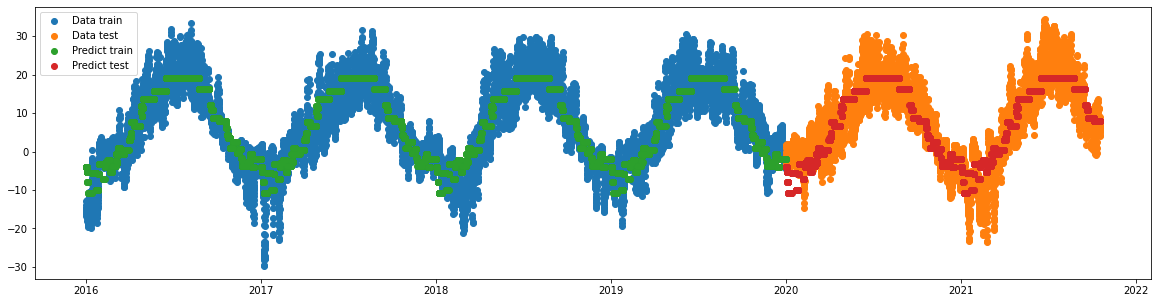

In [ ]:
# 2.1) Decision Tree + dayofyear + настройка параметров

# model = DecisionTreeRegressor(max_depth=5)  # Заменяем модель


# Собираем все шаги воедино

# Новый признак: косинус от дня в году
# data['cos_dayofyear'] = np.cos((data['dayofyear'] - 1) / 366 * 2 * np.pi)
data['dayofyear'] = data['date'].dt.dayofyear # <<<<<<< Вот здесь заменили признак X

# Заново переразбиваем датасет на train-test, чтобы изменения применились
data_train = data[data['date'] < '2020-01-01']
data_test = data[data['date'] >= '2020-01-01']

# Из train-test формируем X_train, X_test
X_train = pd.DataFrame()
X_train['dayofyear'] = data_train['dayofyear']  # <<<<<<< Вот здесь заменили модель
# X_train[другой признак] = data_train[другой признак] # <<<<<<< Вот здесь можно добавить больше признаков
X_test = pd.DataFrame()
X_test['dayofyear'] = data_test['dayofyear']  # <<<<<<< Вот здесь заменили модель
# X_train[другой признак] = data_train[другой признак] # <<<<<<< Вот здесь можно добавить больше признаков
# "y" оставляем прежним
y_train = data_train['T']
y_test = data_test['T']

# Создаем модель и обучаем ее
model = DecisionTreeRegressor(max_depth=6) # <<<<<<< Вот здесь заменили модель
model.fit(X_train, y_train)

# Делаем прогноз
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Печатаем графики
plt.figure(figsize=(20, 5))
plt.scatter(data_train['date'], y_train, label='Data train')
plt.scatter(data_test['date'], y_test, label='Data test')
plt.scatter(data_train['date'], pred_train, label='Predict train')
plt.scatter(data_test['date'], pred_test, label='Predict test')
plt.legend()

# Смотрим на величину ошибки
print('Средняя ошибка на обучающей выборке =', mean_absolute_error(y_train, pred_train))
print('Средняя ошибка на тестовой выборке =', mean_absolute_error(y_test, pred_test))

# 1) LinearRegression + cos_dayofyear
# Средняя ошибка на обучающей выборке = 4.273310125395435
# Средняя ошибка на тестовой выборке = 4.578715441934872

# 2) DecisionTreeRegressor + dayofyear
# Средняя ошибка на обучающей выборке = 3.6437873063246125
# Средняя ошибка на тестовой выборке = 4.647444490245206

# 2.1) DecisionTreeRegressor + dayofyear + настройка параметров
# Средняя ошибка на обучающей выборке = 3.7469198089127693
# Средняя ошибка на тестовой выборке = 4.545731192829994

Модель 2.2 Decision Tree + dayofyear + настройка параметров

Средняя ошибка на обучающей выборке = 3.426350860952302
Средняя ошибка на тестовой выборке = 4.335042389015882


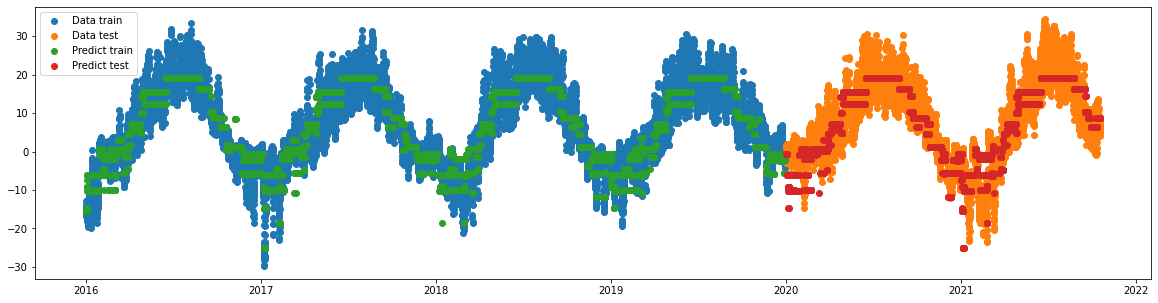

In [ ]:
# 2.1) Decision Tree + dayofyear + настройка параметров

# model = DecisionTreeRegressor(max_depth=5)  # Заменяем модель


# Собираем все шаги воедино

# Новый признак: косинус от дня в году
# data['cos_dayofyear'] = np.cos((data['dayofyear'] - 1) / 366 * 2 * np.pi)
data['dayofyear'] = data['date'].dt.dayofyear # <<<<<<< Вот здесь заменили признак X

# Заново переразбиваем датасет на train-test, чтобы изменения применились
data_train = data[data['date'] < '2020-01-01']
data_test = data[data['date'] >= '2020-01-01']

# Из train-test формируем X_train, X_test
X_train = pd.DataFrame()
X_train['dayofyear'] = data_train['dayofyear']  # <<<<<<< Вот здесь заменили модель
X_train['P'] = data_train['P'] # <<<<<<< Вот здесь можно добавить больше признаков
X_train['N'] = data_train['N']
X_test = pd.DataFrame()
X_test['dayofyear'] = data_test['dayofyear']  # <<<<<<< Вот здесь заменили модель
X_test['P'] = data_test['P'] # <<<<<<< Вот здесь можно добавить больше признаков
X_test['N'] = data_test['N']
# "y" оставляем прежним
y_train = data_train['T']
y_test = data_test['T']

# Создаем модель и обучаем ее
model = DecisionTreeRegressor(max_depth=6) # <<<<<<< Вот здесь заменили модель, пробовал 10
model.fit(X_train, y_train)

# Делаем прогноз
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Печатаем графики
plt.figure(figsize=(20, 5))
plt.scatter(data_train['date'], y_train, label='Data train')
plt.scatter(data_test['date'], y_test, label='Data test')
plt.scatter(data_train['date'], pred_train, label='Predict train')
plt.scatter(data_test['date'], pred_test, label='Predict test')
plt.legend()

# Смотрим на величину ошибки
print('Средняя ошибка на обучающей выборке =', mean_absolute_error(y_train, pred_train))
print('Средняя ошибка на тестовой выборке =', mean_absolute_error(y_test, pred_test))

# 1) LinearRegression + cos_dayofyear
# Средняя ошибка на обучающей выборке = 4.273310125395435
# Средняя ошибка на тестовой выборке = 4.578715441934872

# 2) DecisionTreeRegressor + dayofyear
# Средняя ошибка на обучающей выборке = 3.6437873063246125
# Средняя ошибка на тестовой выборке = 4.647444490245206

# 2.1) DecisionTreeRegressor + dayofyear + настройка параметров
# Средняя ошибка на обучающей выборке = 3.7469198089127693
# Средняя ошибка на тестовой выборке = 4.545731192829994

# 2.2) DecisionTreeRegressor + dayofyear + настройка параметров + P Давление в качестве эксперимента
# Средняя ошибка на обучающей выборке = 3.475915401505911
# Средняя ошибка на тестовой выборке = 4.418481056636242

# 2.2) DecisionTreeRegressor + dayofyear + настройка параметров + P + N Облачность
#В одной из статей указано, что температура зависит от количества солнечных лучей попадающих на землю
#Исходя из этого предположения, чем выше облачность, тем ниже температура, если это так,
#то график будет более точным с учетом облачности

# Средняя ошибка на обучающей выборке = 3.426350860952302
# Средняя ошибка на тестовой выборке = 4.335042389015882